In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from numpy import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import KFold
from sklearn import neighbors
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import zero_one_loss
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cm
import timeit
from sklearn import svm
from sklearn.metrics import hinge_loss
from sklearn.linear_model import SGDClassifier
import copy

%matplotlib inline

pathToDataset = "../../Twitter-Absolute-Sigma-500.csv"
data = pandas.read_csv(pathToDataset, sep=",",encoding="utf8")


Retirer des données à étudier la dernière colonne correspondant au résultat (buzz ou pas buzz)

In [2]:
df_nonNormalized = data.iloc[:, :77]
print(df_nonNormalized.shape)
y = data.iloc[:,77]
df_nonNormalized.head()


(140707, 77)


,NCD_0,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,...,ADL_4,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6
0,889,939,960,805,805,1143,1121,549,613,587,...,1,1,1,889,939,960,805,805,1143,1121
1,542,473,504,626,647,795,832,366,288,318,...,1,1,1,542,473,504,626,647,795,832
2,92,99,196,100,184,79,162,66,59,118,...,1,1,1,92,99,196,100,184,79,162
3,90,87,92,344,184,848,184,83,78,76,...,1,1,1,90,87,92,344,184,848,184
4,169,98,101,90,96,95,185,141,68,85,...,1,1,1,169,98,101,90,96,95,185


In [3]:
column = df_nonNormalized
column[column==0] = 1
stdColumns = column.std()
stdColumns[stdColumns == 0] = 1
df_Normalized =(df_nonNormalized - df_nonNormalized.mean()) / stdColumns

# Quelques exemples 

In [25]:
# n : number of observations we wish to display
def plotBuzz(originalData,n,withbuzz,withoutbuzz):
    
    notBuzzSample = random.random_integers(0,np.size(y[y==0]),n)
    buzzSample = random.random_integers(0,np.size(y[y==1]),n)
    notbuzzindex = np.where(y==0)[0][notBuzzSample]
    buzzindex = np.where(y==1)[0][buzzSample]
    times=["t1","t2","t3","t4","t5","t6","t7"]
    
    varsToDisplay= np.arange(0,77,7)
    variableNames = originalData.iloc[:,varsToDisplay].columns
    variableNames = list(map(lambda x : x.split("_")[0],variableNames))
    
    buzz = originalData.iloc[buzzindex,:]
    notbuzz = originalData.iloc[notbuzzindex,:]
    
    x= np.arange(0,7)
    gs = gridspec.GridSpec(6, 2)
    
    for i in range(0,7) : 
            fig = plt.figure(num=1, figsize=(18, 20), dpi=100, facecolor='w', edgecolor='k')
            ax = fig.add_subplot(gs[i])
            if withbuzz == 1 :
                ax.plot(x,buzz.iloc[:,i:i+7].transpose(),'-o', label = 'buzz')
            if withoutbuzz == 1 : 
                ax.plot(x,notbuzz.iloc[:,i:i+7].transpose(),'-^', label = 'no buzz')
            plt.xlabel('t', fontsize=18)
            plt.xticks(range(0,7),times )
            ax.xaxis.set_label_coords(1.02, -0.025)
            plt.title(variableNames[i], fontsize=20)
            ax.legend(loc='best')

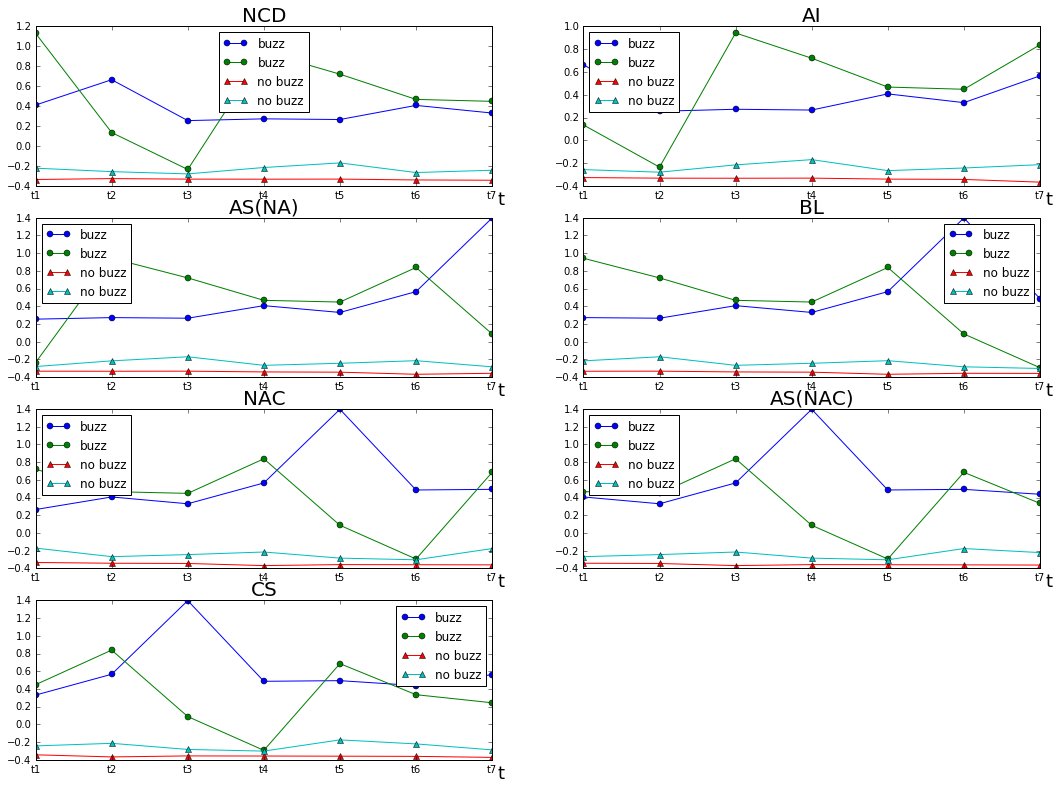

In [26]:
plotBuzz(df_Normalized,2,1,1)

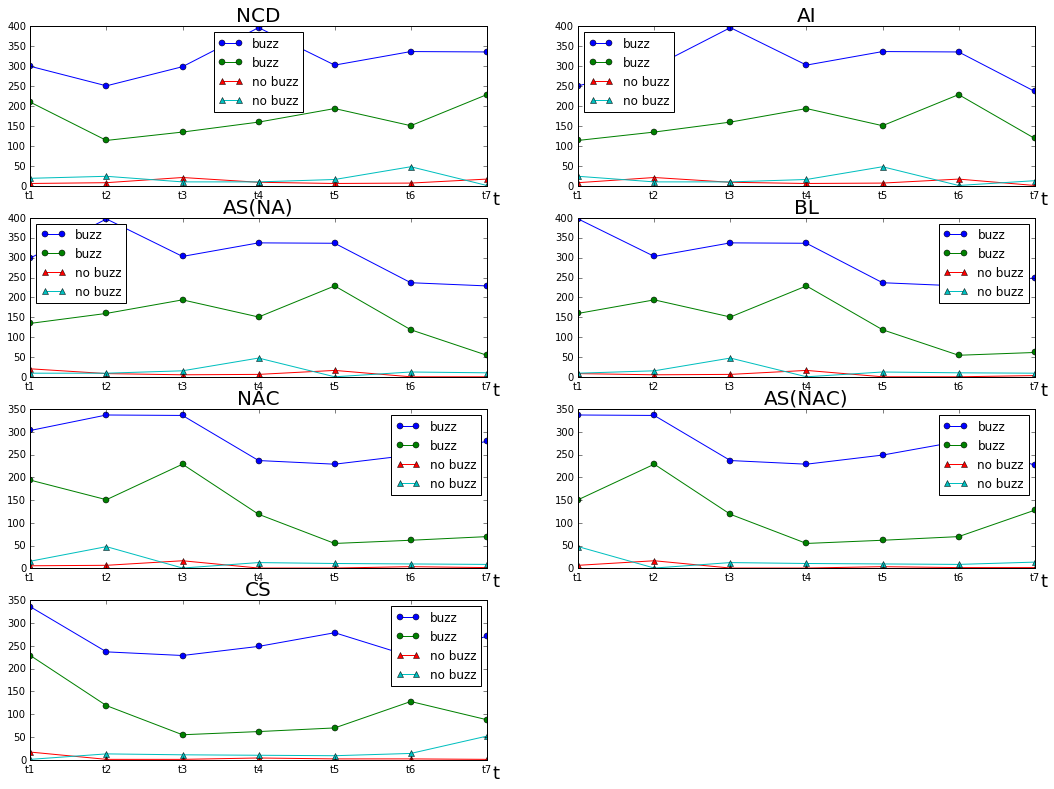

In [27]:
plotBuzz(df_nonNormalized,2,1,1)

Premiers indices de chaque variable

In [7]:
t = []
for i in range(0,76) : 
    ind = i %7
    if(ind == 0):
        t.append(i)

t = np.asarray(t)

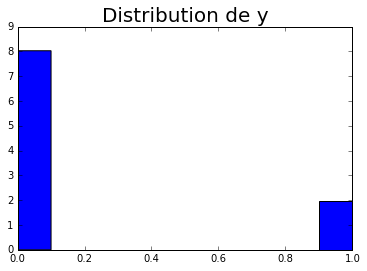

In [8]:
plt.hist(y,normed=True)
plt.title("Distribution de y", fontsize=20)

A partir de l'histogramme précédent, nous nous apercevons qu'on a une distribution de y déséquilibrée (un ratio de 8 pour 2). 
Biaiser la base de données : Prendre les observations des y=0 et y=1 de même taille.

In [9]:
notBuzzSample = random.random_integers(0,np.size(y[y==0]),np.size(y[y==1]))
notbuzz = np.where(y==0)[0][notBuzzSample]
buzz = np.where(y==1)[0]
X_unif = pandas.concat([df_nonNormalized.iloc[notbuzz,:],df_nonNormalized.iloc[buzz,:]],axis=0)
y_unif = pandas.concat([y.iloc[notbuzz],y.iloc[buzz]],axis=0)

In [10]:
print("X_unif",X_unif.shape)
print("y_unif",y_unif.shape)

X_unif (55550, 77)
y_unif (55550,)


# 1.Tentative de sélection de variables : Random Forest
On utilise le random forest sur toutes les variables à un seul instant (t=0) pour essayer de voir s'il y en a certaines qui se démarquent, en utilisant les importances de chacunes.

In [37]:
forest = RandomForestClassifier(n_estimators=5,random_state=1234)

forest.fit(X_unif, y_unif)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

(-1, 77)

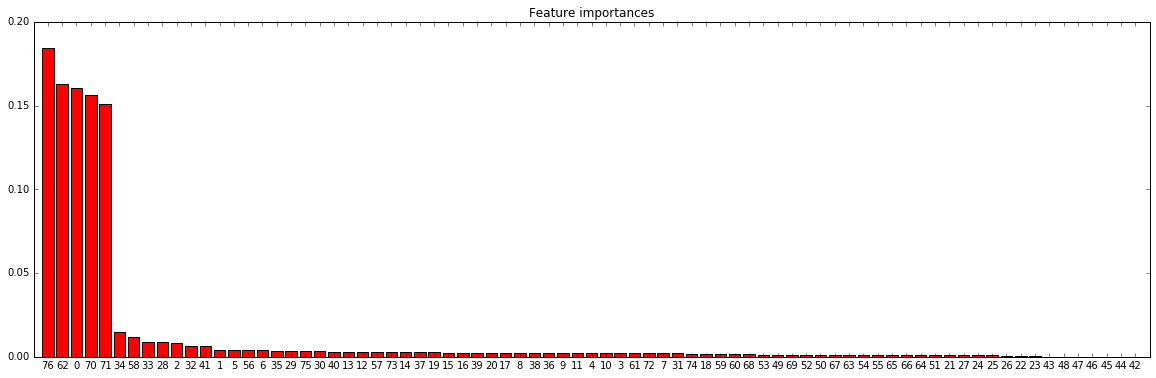

In [38]:
# Plot the feature importances of the forest
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(df_nonNormalized.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(df_nonNormalized.shape[1]), indices)
plt.xlim([-1, df_nonNormalized.shape[1]])

([<matplotlib.axis.XTick at 0x9ed518>,
 <a list of 9 Text xticklabel objects>)

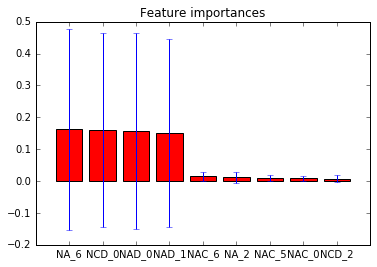

In [39]:
plt.title("Feature importances")
plt.bar(range(1,10), importances[indices][1:10],
       color="r", yerr=std[indices[1:10]], align="center")
plt.xticks(range(1,10), df_nonNormalized[indices[1:10]].columns)

## Selection de features avec SelectModel

In [40]:
# threshold chosen is the mean (by default) (equivalent to importances[importances>np.mean(importances)])
model = SelectFromModel(forest, prefit=True)
X_new = model.transform(X_unif)

In [46]:
test = pandas.DataFrame(X_new)
importantVariableIndexes = model.get_support(range(0,77))
selectedVariables = X_unif.columns[importantVariableIndexes]

print("Les variables sélectionnées pour l'étude :",selectedVariables.tolist())

Les variables sélectionnées pour l'étude : ['NCD_0', 'NAC_6', 'NA_6', 'NAD_0', 'NAD_1', 'NAD_6']


# 2. Agrégation de variables (features supplémentaires)

In [56]:
indices_variables_auteurs = [7,49,56]

Ajout de nouvelles variables (colonnes) de l'accroissement entre t=0 et t=6 pour chacun des types des variables.

In [54]:
accroissements = pandas.DataFrame({})
for i in t :
    maxes = df_nonNormalized.iloc[:,i:i+7].max(1)
    column = df_nonNormalized.iloc[:,i]
    # Pour les variables qui commencent a 0, eviter de diviser par 0
    column[column==0] = 1
    accroissements[i] = (maxes - df_nonNormalized.iloc[:,i])/column
accroissements.columns = df_nonNormalized.iloc[:,t].columns + "_increase"
#df_nonNormalized = pandas.concat([df_nonNormalized,accroissements],axis =1)

c:\users\wymeka\documents\python\python\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 3. Méthode 1 : K-NN neighbours classifier

## Cross-validation testing (using 5 folds)

In [51]:
def knnClassifier(data,y,n_jobs):
    predicted = pandas.DataFrame({})
    scores = np.zeros((10,5))
    f1scores = np.zeros((10,5))
    for n_neighbors in range(1,11):
        clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform",metric="manhattan",p=2,n_jobs=n_jobs)
        predicted[n_neighbors -1] = cross_val_predict(clf, data,y, cv=5)
        scores[n_neighbors - 1] = 1 - zero_one_loss(y,predicted[n_neighbors-1],normalize=True)
        f1scores[n_neighbors - 1] = f1_score(y,predicted[n_neighbors -1])
    mean_scores = scores.mean(1)
    mean_f1scores = f1scores.mean(1)
    kmax = mean_scores.argmax() 
    print("K choisi : ",kmax," pour le score (0/1 loss) : ", mean_scores[kmax -1])
    print("K choisi : ",kmax," pour le score (F1 score) : ", mean_f1scores[kmax -1])
    print("La matrice de confusion pour le meilleur k :\n",cm(y,predicted[kmax]))

Classifier avec toutes les variables d'accroissements : 

In [ ]:
start_time = timeit.default_timer()
knnClassifier(accroissements,y,-1)
elapsed = timeit.default_timer() - start_time
print(elapsed,"seconds")

Classifier qu'avec  les variables d'accroissement d'auteurs :

In [57]:
knnClassifier(accroissements.iloc[:,np.divide(indices_variables_auteurs,7)],y,-1)

K choisi :  9  pour le score (0/1 loss) :  0.79450205036
K choisi :  9  pour le score (F1 score) :  0.275694496631
La matrice de confusion pour le meilleur k :
 [[108881   4051]
 [ 24001   3774]]


Classifier qu'avec les variables liées aux discussions : 

In [58]:
indices_contributions_variables = np.setdiff1d(np.arange(0,11),np.divide(indices_variables_auteurs,7))

In [59]:
knnClassifier(accroissements.iloc[:,indices_contributions_variables],y,-1)

K choisi :  9  pour le score (0/1 loss) :  0.81058511659
K choisi :  9  pour le score (F1 score) :  0.377144192568
La matrice de confusion pour le meilleur k :
 [[108254   4678]
 [ 21501   6274]]


In [45]:
knnClassifier(X_unif,y_unif,-1)

K choisi :  8  pour le score :  0.953429342934
La matrice de confusion pour le meilleur k :
 [[26622  1153]
 [ 1314 26461]]


In [52]:
knnClassifier(X_unif.iloc[:,importantVariableIndexes],y_unif,-1)

K choisi :  8  pour le score (0/1 loss) :  0.95198919892
K choisi :  8  pour le score (F1 score) :  0.951633086088
La matrice de confusion pour le meilleur k :
 [[26440  1335]
 [ 1290 26485]]


# 4. Méthode 2 : SVM 

Nous utilisons ici un modèle SVM linéaire pour des raisons computationnelles.
Le temps de calcul d'un modèle SVM polynomial , de degré 3 par exemple, prend énormément de temps à "fitter" pour notre jeu de données.

In [61]:
def weights(y):
    zeroPercentage = sum(y==0)/sum(y==1)
    weights = np.ones(y.size)
    weights[weights==1]= zeroPercentage
    return weights

In [11]:
y_svm = copy.deepcopy(y)
y_svm[y_svm==0] = -1
def linearSVM(data,y):
    linear_svc = SGDClassifier(loss="hinge", alpha=0.01, class_weight ='balanced',n_iter=200, fit_intercept=True)
    #linear_svc = svm.LinearSVC(C=1,random_state=1234)
    y_predicted = cross_val_predict(linear_svc, data,y, cv=5)
    scores = hinge_loss(y,y_predicted)
    scoreszero=  1 - zero_one_loss(y,y_predicted,normalize=True)
    print(scores.mean())
    print(scoreszero.mean())
    print(cm(y,y_predicted))

In [119]:
np.unique(y_svm)

array([-1,  1], dtype=int64)

In [120]:
linearSVM(accroissements,y)

NameError: name 'accroissements' is not defined

In [61]:
linearSVM(accroissements.iloc[:,indices_contributions_variables], y)

0.890886736268


In [ ]:
linearSVM(accroissements.iloc[:,np.divide(indices_variables_auteurs,7)],y)

In [21]:
linearSVM(X_unif,y_unif)

0.546102610261
0.953897389739
[[26774  1001]
 [ 1560 26215]]


In [12]:
linearSVM(df_nonNormalized,y)

0.842907602323
0.959696390371
[[108844   4088]
 [  1583  26192]]
